In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

In [3]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [4]:
df_doc_wc = df_doc[df_doc['Type'] == 'WC']

df_doc_wc

,Treatment,Campaign,Date,Location,NPOC Conc (mg/L),TN Conc (mg/L),Depth,Notes,Type,Time,Dil Factor,NPOC_uM,TN_uM,dil_fac,NPOC_uM_std,TN_uM_std,code
Sample ID,,,,,,,,,,,,,,,,,
211901,P2F,GOM2021,7/15/2021,St.MK,1.22200,0.1955,16.7,NaN,WC,NaN,NaN,101.833333,13.964286,NaN,2.988328,0.517500,St.MK_GOM2021
211902,P2F,GOM2021,7/15/2021,St.MK,1.22350,0.182,16.7,NaN,WC,NaN,NaN,101.958333,13.000000,NaN,2.991996,0.481765,St.MK_GOM2021
211903,P2F,GOM2021,7/15/2021,St.MK,1.35050,0.11485,14.0,NaN,WC,NaN,NaN,112.541667,8.203571,NaN,3.302567,0.304015,St.MK_GOM2021
211904,P2F,GOM2021,7/15/2021,St.MK,1.57650,BDL,14.0,NaN,WC,NaN,NaN,131.375000,0.323571,NaN,3.855237,0.011991,St.MK_GOM2021
211905,P2F,GOM2021,7/15/2021,St.MK,1.45250,0.1677,10.0,NaN,WC,NaN,NaN,121.041667,11.978571,NaN,3.552002,0.443912,St.MK_GOM2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225036,P2F,GOM22SU,7/21/2022,St.12,0.97345,0.066635,70.6,TN STD LOW,WC,NaN,NaN,81.120833,4.759643,NaN,0.321938,0.028041,St.12_GOM22SU
225037,P2F,GOM22SU,7/21/2022,St.12,1.04600,0.076015,45.0,TN STD LOW,WC,NaN,NaN,87.166667,5.429643,NaN,0.345932,0.031989,St.12_GOM22SU
225038,P2F,GOM22SU,7/21/2022,St.12,1.06300,0.07098,21.0,TN STD LOW,WC,NaN,NaN,88.583333,5.070000,NaN,0.351554,0.029870,St.12_GOM22SU


In [14]:
#DOC slopes pore water 
df_doc_wc = df_doc_wc.dropna(subset=["NPOC_uM"])
#df_doc_wc = df_doc_wc[df_doc_wc['NPOC_uM'] >= 1]

df_cal = df_doc_wc
df_cal['doc_mol_per_m3'] =  df_cal['NPOC_uM'] / 1000000 * 1000

codes = df_cal['code'].unique()

print(codes)
len(codes)
df_cal.columns

['St.MK_GOM2021' 'St.5B_GOM2021' 'St.4_GOM2021' 'St.14_GOM2021'
 'St.9_GOM2021' 'St.13_GOM2021' 'St.2_GOM2021' 'St.15_GOM2021'
 'St.16_GOM2021' 'St.11_GOM2021' 'St.7_GOM2021' 'St.ML_GOM2021'
 'St.5B_GOM21FA' 'St.6_GOM21FA' 'St.4_GOM21FA' 'St.MK_GOM21FA'
 'St.MK-2_GOM21FA' 'St.7_GOM21FA' 'St.14_GOM21FA' 'St.9_GOM21FA'
 'St.14.5_GOM21FA' 'St.15_GOM21FA' 'St.2_GOM21FA' 'St.16_GOM21FA'
 'St.12_GOM21FA' 'St.11_GOM21FA' 'St.13_GOM21FA' 'St.16-2_GOM21FA'
 'St.7_GOM22SP' 'St.16_GOM22SP' 'St.5B_GOM22SP' 'St.15_GOM22SP'
 'St.14_GOM22SP' 'St.2_GOM22SP' 'St.13_GOM22SP' 'St.MK_GOM22SP'
 'St.4_GOM22SP' 'St.4_GOM22SU' 'St.5B_GOM22SU' 'St.13_GOM22SU'
 'St.2_GOM22SU' 'St.7_GOM22SU' 'St.15_GOM22SU' 'St.16_GOM22SU'
 'St.11_GOM22SU' 'St.MK_GOM22SU' 'St.9_GOM22SU' 'St.9_GOM22SP'
 'St.14_GOM22SU' 'St.12_GOM22SU']


Index(['Treatment', 'Campaign', 'Date', 'Location', 'NPOC Conc (mg/L)',
       'TN Conc (mg/L)', 'Depth', 'Notes', 'Type', 'Time', 'Dil Factor',
       'NPOC_uM', 'TN_uM', 'dil_fac', 'NPOC_uM_std', 'TN_uM_std', 'code',
       'doc_mol_per_m3'],
      dtype='object')

for each code in codes: 
    ds = df_doc_wc[df_doc_wc['code'] == code]
    ds 

Shaded area for code St.MK_GOM2021: 0.1408130613806886


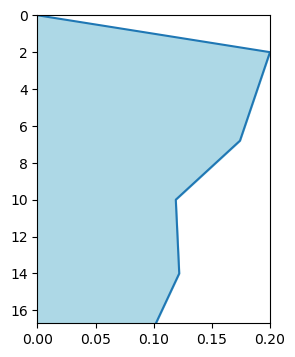

Shaded area for code St.5B_GOM2021: 0.1256874166546


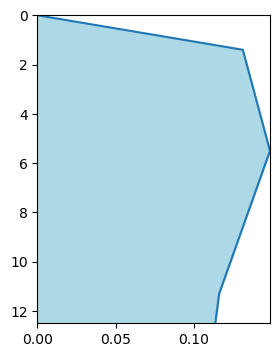

Shaded area for code St.4_GOM2021: 0.07108685753461078


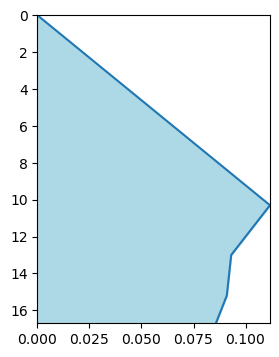

Shaded area for code St.14_GOM2021: 0.082693179924099


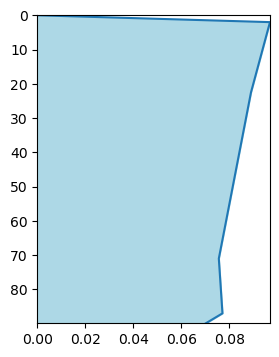

Shaded area for code St.9_GOM2021: 0.08005703218708805


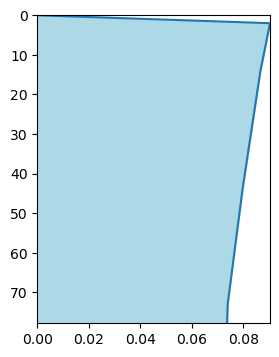

Shaded area for code St.13_GOM2021: 0.06892425724766615


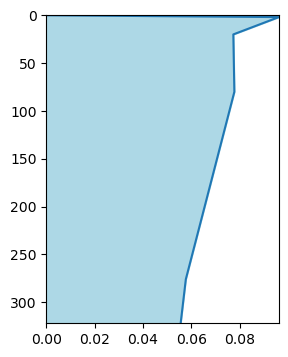

Shaded area for code St.2_GOM2021: 0.0994263297175


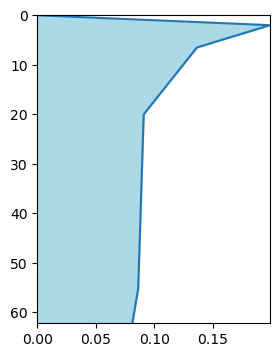

Shaded area for code St.15_GOM2021: 0.07602039838817543


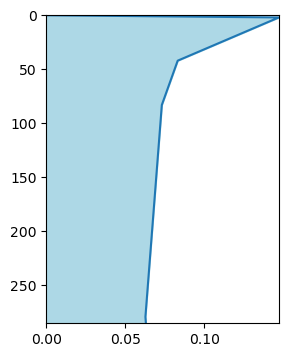

Shaded area for code St.16_GOM2021: 0.13223272357947155


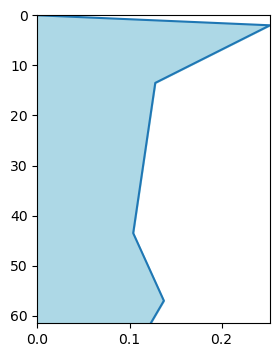

Shaded area for code St.11_GOM2021: 0.11272909838386364


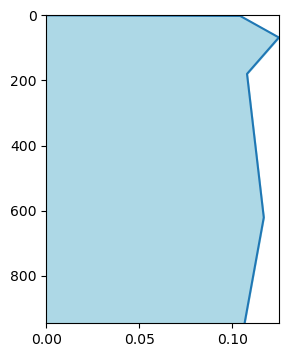

Shaded area for code St.7_GOM2021: 0.13045833332727275


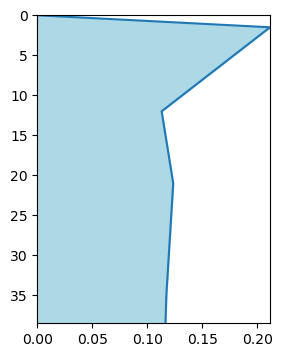

Shaded area for code St.ML_GOM2021: 0.15319058909948277


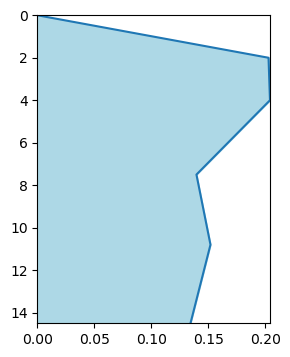

Shaded area for code St.5B_GOM21FA: 0.11749398713617887


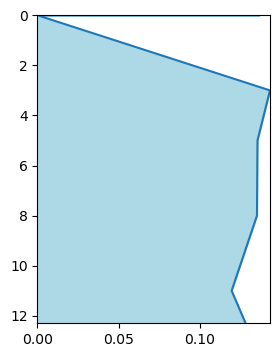

Shaded area for code St.6_GOM21FA: 0.12361795342113971


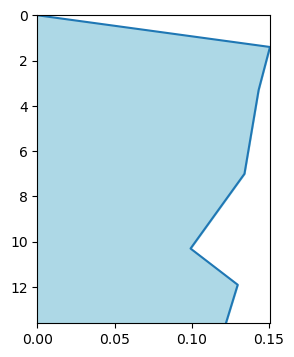

Shaded area for code St.4_GOM21FA: 0.10028609871375


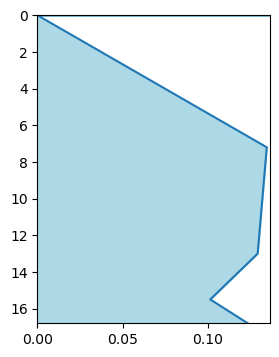

Shaded area for code St.MK_GOM21FA: 0.14777058081954544


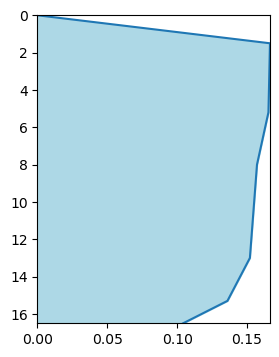

Shaded area for code St.MK-2_GOM21FA: 0.1242398182874436


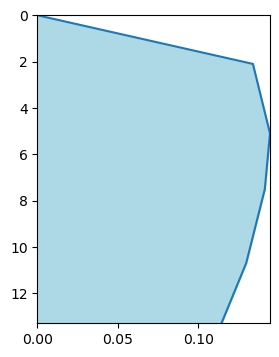

Shaded area for code St.7_GOM21FA: 0.09583653510175001


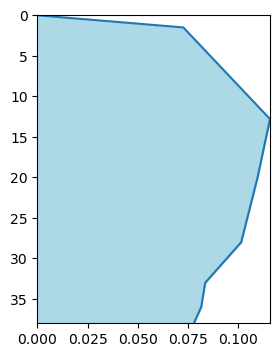

Shaded area for code St.14_GOM21FA: 0.08031138182011299


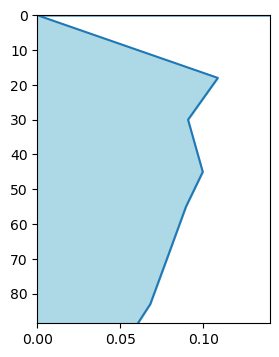

Shaded area for code St.9_GOM21FA: 0.09340725117566999


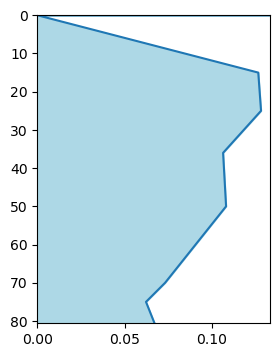

Shaded area for code St.14.5_GOM21FA: 0.07852152238737864


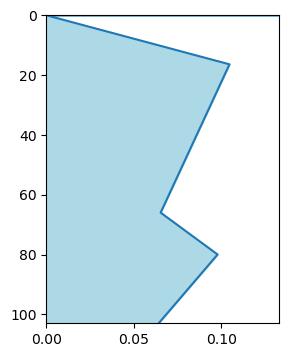

Shaded area for code St.15_GOM21FA: 0.05486808273122531


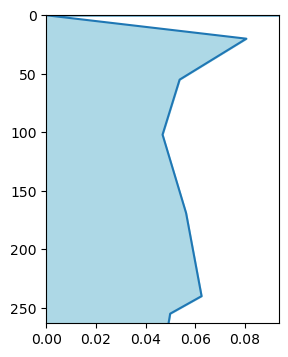

Shaded area for code St.2_GOM21FA: 0.08146310934218137


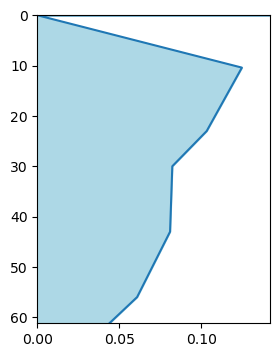

Shaded area for code St.16_GOM21FA: 0.0867092737233507


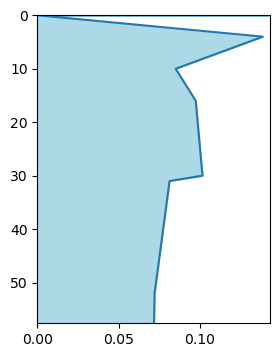

Shaded area for code St.12_GOM21FA: 0.048414677631526314


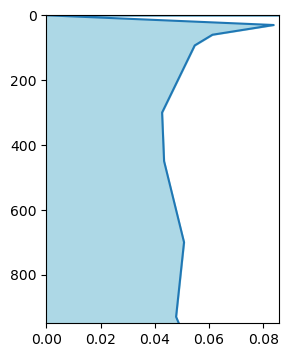

Shaded area for code St.11_GOM21FA: 0.05362000796965847


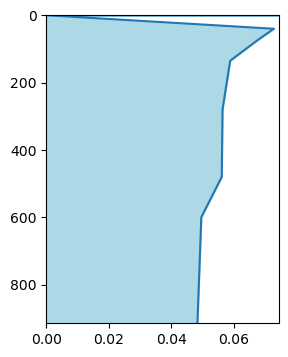

Shaded area for code St.13_GOM21FA: 0.05018066768985267


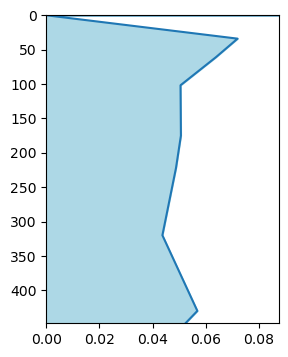

Shaded area for code St.16-2_GOM21FA: 0.09660179338387988


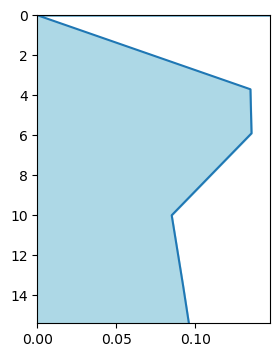

Shaded area for code St.7_GOM22SP: 0.0678354033798278


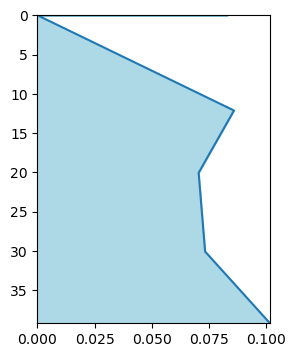

Shaded area for code St.16_GOM22SP: 0.07174014136910714


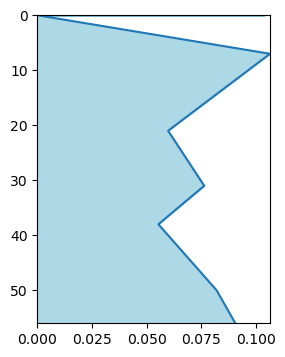

Shaded area for code St.5B_GOM22SP: 0.09584229599625001


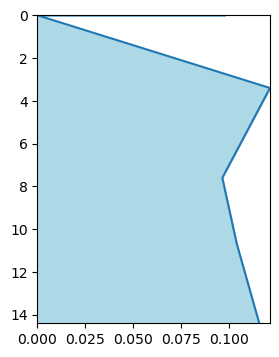

Shaded area for code St.15_GOM22SP: 0.061542705161282345


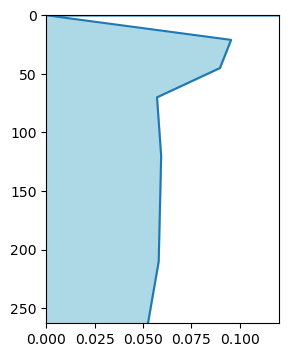

Shaded area for code St.14_GOM22SP: 0.09362620738187499


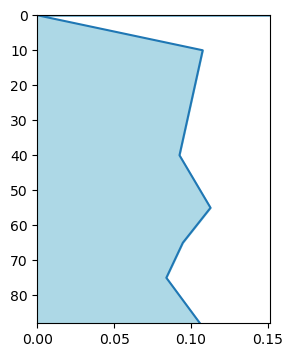

Shaded area for code St.2_GOM22SP: 0.09511509615280771


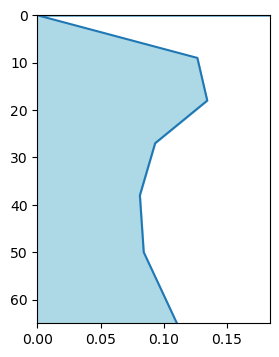

Shaded area for code St.13_GOM22SP: 0.05996030405337837


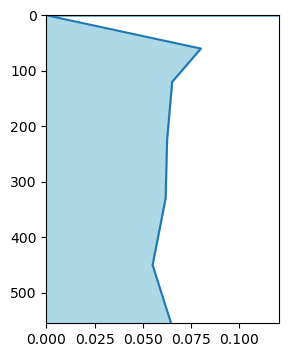

Shaded area for code St.MK_GOM22SP: 0.09925183822617649


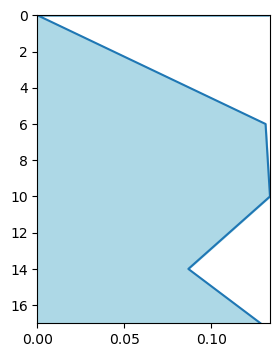

Shaded area for code St.4_GOM22SP: 0.12432421874374999


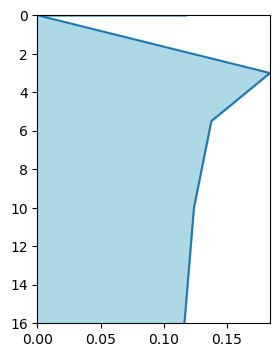

Shaded area for code St.4_GOM22SU: 0.12876997833394346


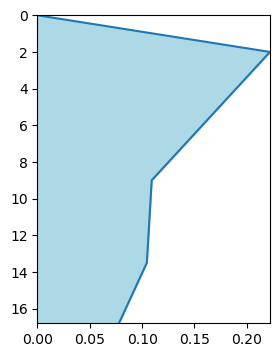

Shaded area for code St.5B_GOM22SU: 0.1848192791095455


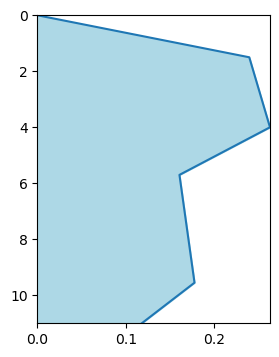

Shaded area for code St.13_GOM22SU: 0.059161818053775614


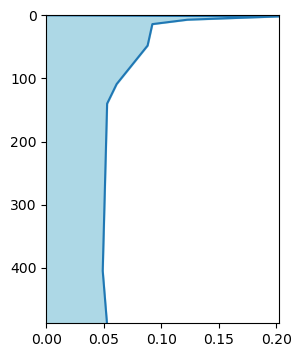

Shaded area for code St.2_GOM22SU: 0.04548650915187043


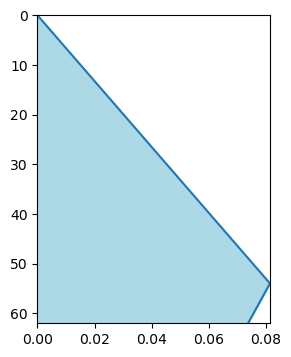

Shaded area for code St.7_GOM22SU: 0.12114573121678923


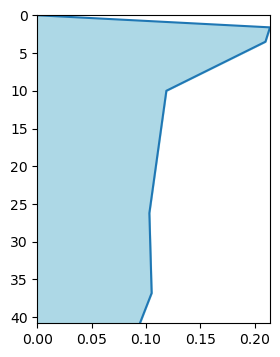

Shaded area for code St.15_GOM22SU: 0.07701755325744926


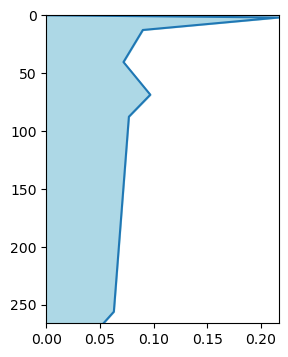

Shaded area for code St.16_GOM22SU: 0.1116279580246864


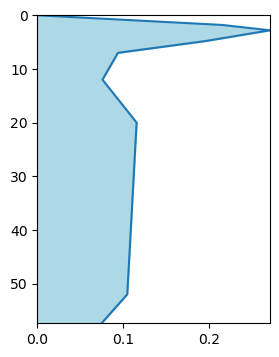

Shaded area for code St.11_GOM22SU: 0.05577437907562718


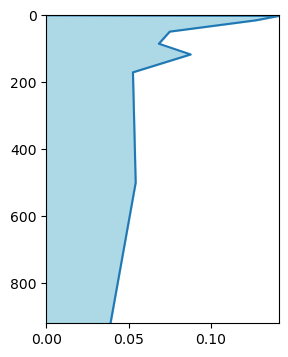

Shaded area for code St.MK_GOM22SU: 0.1286063880844291


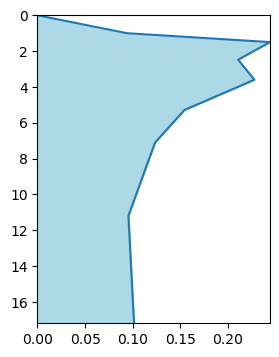

Shaded area for code St.9_GOM22SU: 0.0697756540074557


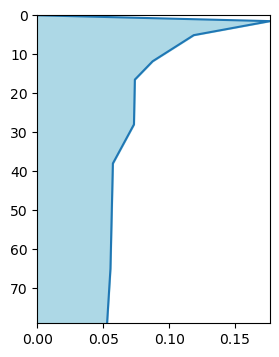

Shaded area for code St.9_GOM22SP: 0.09229882585216959


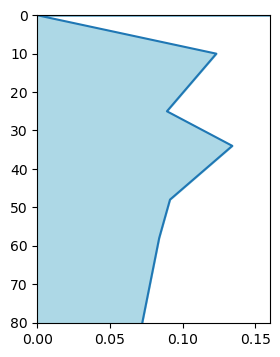

Shaded area for code St.14_GOM22SU: 0.08930254966037793


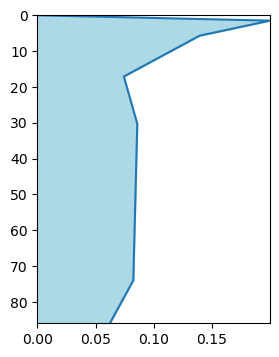

Shaded area for code St.12_GOM22SU: 0.06381027296798544


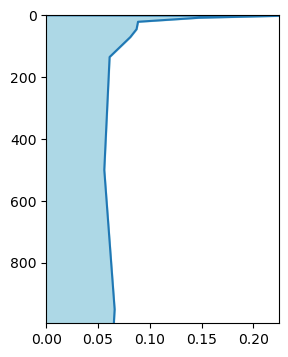

,Depth,doc_mol_per_m3_wc
code,,
St.MK_GOM2021,16.7,0.140813
St.5B_GOM2021,12.5,0.125687
St.4_GOM2021,16.7,0.071087
St.14_GOM2021,89.9,0.082693
St.9_GOM2021,77.8,0.080057
St.13_GOM2021,322.0,0.068924
St.2_GOM2021,62.2,0.099426
St.15_GOM2021,285.0,0.076020
St.16_GOM2021,61.5,0.132233


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have df_doc_wc DataFrame and 'codes' list defined

Frames = []

for code in codes:
    ds = df_doc_wc[df_doc_wc['code'] == code]
    ds = ds.groupby('Depth').agg({'NPOC_uM': 'mean', 'Depth': 'mean'}).reset_index(drop=True)

    new_row = pd.DataFrame([np.nan] * len(ds.columns)).T

    new_row.columns = ds.columns
    new_row['Depth'] = 0 
    new_row['NPOC_uM'] = 0 
    
    ds['NPOC_uM'] = ds['NPOC_uM'] / 1000000 * 1000
    
    selected_data = pd.concat([ds, new_row])
    selected_data = selected_data.sort_values(by=['Depth'])
    
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 4)) 
    axs.plot(selected_data['NPOC_uM'], selected_data['Depth'])
    axs.set_ylim(selected_data['Depth'].max(), 0)
    axs.set_xlim(0, selected_data['NPOC_uM'].max())
    
    # Shade the area to the left of the data points
    axs.fill_betweenx(selected_data['Depth'], selected_data['NPOC_uM'], color='lightblue')
    
    # Calculate the shaded area
    shaded_area = np.trapz(selected_data['NPOC_uM'], selected_data['Depth']) / selected_data['Depth'].max()
    print(f"Shaded area for code {code}: {shaded_area}")

    max_d = selected_data['Depth'].max()

    dic = {'code':[code],
           'Depth': [max_d],
           'doc_mol_per_m3_wc':[shaded_area]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)

    plt.show()

stocks_doc_wc = pd.concat(Frames, axis=0, ignore_index=False)

stocks_doc_wc

In [29]:


stocks_doc_wc.to_csv('../Dissertation_projects/Data/Stats_data_sets/Water_col_DOC_stocks.csv')

stocks_doc_wc

,Depth,doc_mol_per_m3_wc
code,,
St.MK_GOM2021,16.7,0.140813
St.5B_GOM2021,12.5,0.125687
St.4_GOM2021,16.7,0.071087
St.14_GOM2021,89.9,0.082693
St.9_GOM2021,77.8,0.080057
St.13_GOM2021,322.0,0.068924
St.2_GOM2021,62.2,0.099426
St.15_GOM2021,285.0,0.076020
St.16_GOM2021,61.5,0.132233
